In [1]:
import os

import mne
import snirf
from mne.io import read_raw_nirx, read_raw_snirf
from mne.preprocessing.nirs import beer_lambert_law, optical_density
from numpy.testing import assert_allclose

from mne_nirs.io import write_raw_snirf

In [1]:
!pip install gdown h5py matplotlib numpy pandas scipy mne@git+https://github.com/mne-tools/mne-python.git@b1cf3107e93cd4f91b2ecad6147cf4706a18dbe1 mne-nirs

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/mne-tools/mne-python.git (to revision b1cf3107e93cd4f91b2ecad6147cf4706a18dbe1) to /private/var/folders/m2/8_k5938s5_l8bzxcjsy3qyk00000gn/T/pip-install-kn43qqmq/mne_2a0d5091e2f944b69c6a640cdda51005
  Running command git clone --filter=blob:none --quiet https://github.com/mne-tools/mne-python.git /private/var/folders/m2/8_k5938s5_l8bzxcjsy3qyk00000gn/T/pip-install-kn43qqmq/mne_2a0d5091e2f944b69c6a640cdda51005
  Running command git rev-parse -q --verify 'sha^b1cf3107e93cd4f91b2ecad6147cf4706a18dbe1'
  Running command git fetch -q https://github.com/mne-tools/mne-python.git b1cf3107e93cd4f91b2ecad6147cf4706a18dbe1
  Running command git checkout -q b1cf3107e93cd4f91b2ecad6147cf4706a18dbe1
  Resolved https://github.com/mne-tools/mne-python.git to commit b1cf3107e93cd4f91b2ecad6147cf4706a18dbe1
  Preparing metadata (setup.py) ... done
  Created wheel for mne: filename=mne-1.4.0.dev97+gb

In [2]:
!gdown --id 1VYtux3p3hcM41FPjmnAwDgc4MM8DBxkg --output Hb_Moments.snirf

/Users/andrewkim/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/andrewkim/Library/Python/3.9/lib/python/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1VYtux3p3hcM41FPjmnAwDgc4MM8DBxkg
From (redirected): https://drive.google.com/uc?id=1VYtux3p3hcM41FPjmnAwDgc4MM8DBxkg&confirm=t&uuid=246e0e20-eb78-4200-9278-02d2c4d80e94
To: /Users/andrewkim/Desktop/Hb_Moments.snirf
100%|████████████████████████████████████████| 173M/173M [00:13<00:00, 12.8MB/s]


In [3]:
%matplotlib inline

import pathlib

import h5py
import matplotlib.pyplot as plt
import nilearn.plotting

import numpy as np
import pandas as pd

import mne
import mne.channels
import mne.io.snirf
import mne_nirs.experimental_design
import mne_nirs.statistics


/Users/andrewkim/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
snirf_file = "SyBBURE/fNIRS_Analysis_Code/9_27_24_KernelTestver1.snirf"
raw = mne.io.snirf.read_raw_snirf(snirf_file)
raw

Loading /Users/andrewkim/Desktop/SyBBURE/fNIRS_Analysis_Code/9_27_24_KernelTestver1.snirf


<RawSNIRF | 9_27_24_KernelTestver1.snirf, 4314 x 800 (212.5 s), ~4.1 MB, data not loaded>

In [5]:
raw.load_data()
raw._data *= 1e-6

Reading 0 ... 799  =      0.000 ...   212.534 secs...


In [6]:
probe_keys = [
    ("detectorLabels", str),
    ("sourceLabels", str),
    ("sourcePos3D", float),
    ("detectorPos3D", float),
]
with h5py.File(snirf_file, "r") as file:
    probe_data = {
        key: np.array(file["nirs"]["probe"][key]).astype(dtype)
        for key, dtype in probe_keys
    }
[*probe_data]

['detectorLabels', 'sourceLabels', 'sourcePos3D', 'detectorPos3D']

In [7]:
raw.annotations.to_data_frame()

,onset,duration,description
0,2024-09-27 22:00:13.998776,210.785963,StartExperiment
1,2024-09-27 22:00:14.015134,10.006742,StartBlankScreen
2,2024-09-27 22:00:24.191294,10.013580,StartCheckerboard
3,2024-09-27 22:00:34.221014,10.008861,StartBlankScreen
4,2024-09-27 22:00:44.229995,10.008610,StartCheckerboard
5,2024-09-27 22:00:54.254741,10.009899,StartBlankScreen
6,2024-09-27 22:01:04.264738,10.090967,StartCheckerboard
7,2024-09-27 22:01:14.371824,10.003965,StartBlankScreen
8,2024-09-27 22:01:24.375868,10.063583,StartCheckerboard
9,2024-09-27 22:01:34.455584,10.009877,StartBlankScreen


In [8]:
with h5py.File(snirf_file, "r") as file:
  ctr = 1
  while (stim:=f"stim{ctr}") in file["nirs"]:
    print(stim, np.array(file["nirs"][stim]["name"]))
    ctr+=1

stim1 b'StartBlankScreen'
stim2 b'StartCheckerboard'
stim3 b'StartExperiment'


In [9]:
with h5py.File(snirf_file, "r") as file:
  df_start_block = pd.DataFrame(data = np.array(file["nirs"]["stim1"]["data"]), columns=[col.decode('UTF-8') for col in file["nirs"]["stim1"]["dataLabels"]])
df_start_block

,Timestamp,Duration,Value,Experiment,BlankScreen.1,BlankScreen.2,BlankScreen.3,BlankScreen.4,BlankScreen.5,BlankScreen.6,...,Checkerboard.1,Checkerboard.2,Checkerboard.3,Checkerboard.4,Checkerboard.5,Checkerboard.6,Checkerboard.7,Checkerboard.8,Checkerboard.9,Checkerboard.10
0,1.015134,10.006742,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21.221014,10.008861,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,41.254741,10.009899,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,61.371824,10.003965,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,81.455584,10.009877,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,101.489335,10.009938,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,121.589760,10.008125,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,141.623520,10.006364,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,161.657265,10.008860,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,181.707683,10.009920,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
with h5py.File(snirf_file, "r") as file:
  df_start_block = pd.DataFrame(data = np.array(file["nirs"]["stim2"]["data"]), columns=[col.decode('UTF-8') for col in file["nirs"]["stim2"]["dataLabels"]])
df_start_block

,Timestamp,Duration,Value,Experiment,BlankScreen.1,BlankScreen.2,BlankScreen.3,BlankScreen.4,BlankScreen.5,BlankScreen.6,...,Checkerboard.1,Checkerboard.2,Checkerboard.3,Checkerboard.4,Checkerboard.5,Checkerboard.6,Checkerboard.7,Checkerboard.8,Checkerboard.9,Checkerboard.10
0,11.191294,10.013580,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,31.229995,10.008610,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51.264738,10.090967,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,71.375868,10.063583,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,91.465550,10.007662,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,111.499374,10.074266,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,131.597971,10.009407,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,151.629975,10.011164,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,171.666202,10.026041,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,191.717702,10.040958,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
# Step 1: Extract events from annotations
events, _ = mne.events_from_annotations(raw, {"StartBlankScreen": 1, "StartCheckerboard": 2})

# Step 2: Define event IDs for BlankScreen and Checkerboard
event_id = {"BlankScreen": 1, "Checkerboard": 2}

# Step 3: Iterate over columns and check if the dimensions match
for col in ['BlankScreen.1', 'BlankScreen.2', 'BlankScreen.3', 'BlankScreen.4', 'BlankScreen.5', 'BlankScreen.6', 
            'BlankScreen.7', 'BlankScreen.8', 'BlankScreen.9', 'BlankScreen.10']:
    # Ensure the lengths match for boolean indexing
    if len(df_start_block[col]) == len(events):
        events[df_start_block[col].values == 1., 2] = event_id["BlankScreen"]

# Step 4: Add Checkerboard events if applicable (assuming similar structure for Checkerboard columns)
for col in ['Checkerboard.1', 'Checkerboard.2', 'Checkerboard.3', 'Checkerboard.4', 'Checkerboard.5', 
            'Checkerboard.6', 'Checkerboard.7', 'Checkerboard.8', 'Checkerboard.9', 'Checkerboard.10']:
    # Ensure the lengths match for boolean indexing
    if len(df_start_block[col]) == len(events):
        events[df_start_block[col].values == 1., 2] = event_id["Checkerboard"]

# Output the modified events
events


Used Annotations descriptions: ['StartBlankScreen', 'StartCheckerboard']


array([[  4,   0,   1],
       [ 42,   0,   2],
       [ 80,   0,   1],
       [117,   0,   2],
       [155,   0,   1],
       [193,   0,   2],
       [231,   0,   1],
       [268,   0,   2],
       [306,   0,   1],
       [344,   0,   2],
       [382,   0,   1],
       [419,   0,   2],
       [457,   0,   1],
       [495,   0,   2],
       [532,   0,   1],
       [570,   0,   2],
       [608,   0,   1],
       [645,   0,   2],
       [683,   0,   1],
       [721,   0,   2],
       [759,   0,   1]])

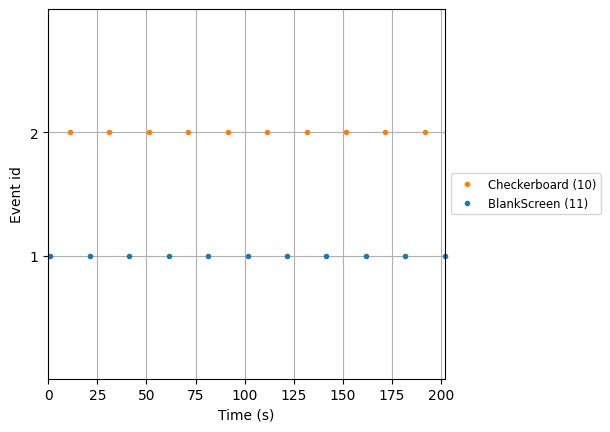

In [16]:
mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info["sfreq"]);

In [17]:
# Convert useful events back to annotations...
event_desc = {v:k for k, v in event_id.items()}
annotations_from_events = mne.annotations_from_events(events, raw.info['sfreq'], event_desc=event_desc)
# Set these annotations on the raw data
raw.set_annotations(annotations_from_events)

<RawSNIRF | 9_27_24_KernelTestver1.snirf, 4314 x 800 (212.5 s), ~30.4 MB, data loaded>

In [18]:
raw_filt = raw.filter(0.01, 0.1, h_trans_bandwidth=0.01, l_trans_bandwidth=0.01)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.11 Hz)
- Filter length: 1241 samples (330.106 s)



/var/folders/m2/8_k5938s5_l8bzxcjsy3qyk00000gn/T/ipykernel_80212/2691433925.py:1: RuntimeWarning: filter_length (1241) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  raw_filt = raw.filter(0.01, 0.1, h_trans_bandwidth=0.01, l_trans_bandwidth=0.01)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]

In [19]:
tmin, tmax = -5, 45
epochs = mne.Epochs(
    raw_filt,
    events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)

Not setting metadata
21 matching events found
Setting baseline interval to [-5.054, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 189 original time points ...
5 bad epochs dropped


In [20]:
epochs.info["chs"][0]

{'loc': array([-1.23936076e-02,  8.90452690e-02,  1.06600916e-02, -1.14113598e-02,
         8.92143326e-02,  6.48209238e-03, -1.33758554e-02,  8.88762054e-02,
         1.48380909e-02,  6.90000000e+02,  0.00000000e+00,             nan]),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'range': 1.0,
 'cal': 1.0,
 'kind': 1100 (FIFFV_FNIRS_CH),
 'coil_type': 307 (FIFFV_COIL_FNIRS_TD_MOMENTS_AMPLITUDE),
 'unit': 107 (FIFF_UNIT_V),
 'coord_frame': 0 (FIFFV_COORD_UNKNOWN),
 'ch_name': 'S1_D1 690 moment0',
 'scanno': 1,
 'logno': 1}

In [21]:
idx_sources = np.array([int(ch.split("_")[0][1:]) - 1 for ch in epochs.info["ch_names"]])
idx_detectors = np.array([int(ch.split("_")[1].split(" ")[0][1:]) - 1 for ch in epochs.info["ch_names"]])
source_positions = np.array(probe_data["sourcePos3D"])[idx_sources]
detector_positions = np.array(probe_data["detectorPos3D"])[idx_detectors]
sds = np.sqrt(np.sum((source_positions - detector_positions) ** 2, axis=1))

In [49]:
idx_channels = np.flatnonzero((sds > 15) & (sds < 30))
blankscreen_evoked = epochs["BlankScreen"].average(picks=idx_channels)
checkerboard_evoked = epochs["Checkerboard"].average(picks=idx_channels)

# make an evoked object for the contrast
blankscreen_checkerboard_evoked = blankscreen_evoked.copy()
blankscreen_checkerboard_evoked._data = blankscreen_evoked._data - checkerboard_evoked._data
print(blankscreen_evoked)
print(checkerboard_evoked)
print(blankscreen_checkerboard_evoked)

<Evoked | 'BlankScreen' (average, N=8), -5.054 – 44.954 s, baseline -5.054 – 0 s, 2340 ch, ~5.6 MB>
<Evoked | 'Checkerboard' (average, N=8), -5.054 – 44.954 s, baseline -5.054 – 0 s, 2340 ch, ~5.6 MB>
<Evoked | 'BlankScreen' (average, N=8), -5.054 – 44.954 s, baseline -5.054 – 0 s, 2340 ch, ~5.6 MB>


In [50]:
print("Shape of BLANKSCREEN data:", blankscreen_evoked.data.shape)  # Should be (n_channels, n_times)
print("Shape of CHECKERBOARD data:", checkerboard_evoked.data.shape)
print("Shape of BLANKSCREEN - CHECKERBOARD data:", blankscreen_checkerboard_evoked.data.shape)


Shape of BLANKSCREEN data: (2340, 189)
Shape of CHECKERBOARD data: (2340, 189)
Shape of BLANKSCREEN - CHECKERBOARD data: (2340, 189)


In [51]:
print("Available time points (BLANKSCREEN):", blankscreen_evoked.times)
print("Available time points (CHECKERBOARD):", checkerboard_evoked.times)
print("Available time points (BLANKSCREEN - CHECKERBOARD):", blankscreen_checkerboard_evoked.times)


Available time points (BLANKSCREEN): [-5.054 -4.788 -4.522 -4.256 -3.99  -3.724 -3.458 -3.192 -2.926 -2.66
 -2.394 -2.128 -1.862 -1.596 -1.33  -1.064 -0.798 -0.532 -0.266  0.
  0.266  0.532  0.798  1.064  1.33   1.596  1.862  2.128  2.394  2.66
  2.926  3.192  3.458  3.724  3.99   4.256  4.522  4.788  5.054  5.32
  5.586  5.852  6.118  6.384  6.65   6.916  7.182  7.448  7.714  7.98
  8.246  8.512  8.778  9.044  9.31   9.576  9.842 10.108 10.374 10.64
 10.906 11.172 11.438 11.704 11.97  12.236 12.502 12.768 13.034 13.3
 13.566 13.832 14.098 14.364 14.63  14.896 15.162 15.428 15.694 15.96
 16.226 16.492 16.758 17.024 17.29  17.556 17.822 18.088 18.354 18.62
 18.886 19.152 19.418 19.684 19.95  20.216 20.482 20.748 21.014 21.28
 21.546 21.812 22.078 22.344 22.61  22.876 23.142 23.408 23.674 23.94
 24.206 24.472 24.738 25.004 25.27  25.536 25.802 26.068 26.334 26.6
 26.866 27.132 27.398 27.664 27.93  28.196 28.462 28.728 28.994 29.26
 29.526 29.792 30.058 30.324 30.59  30.856 31.122 31.388 

In [ ]:
times = np.arange(0, 10, 20)
evoked.plot_topomap(times, ch_type="mag")

In [53]:
chromophore = "hbo"
times = [0, 10, 20, 30, 40]
vlim = (-2, 2)

# Arguments for topomap plotting
plot_topo_kwargs = dict(
    ch_type=chromophore,
    sensors=False,
    image_interp="linear",
    vlim=vlim,
    extrapolate="local",
    contours=0,
    colorbar=False,
    show=False,
)

blankscreen_evoked.plot_topomap([time], axes=ax[0][idx_time], **plot_topo_kwargs)


ValueError: A 2-dimensional array must be passed.

In [52]:
chromophore = "hbo"
times = [0, 10, 20, 30, 40]
vlim = (-2, 2)

# Arguments for topomap plotting
plot_topo_kwargs = dict(
    ch_type=chromophore,
    sensors=False,
    image_interp="linear",
    vlim=vlim,
    extrapolate="local",
    contours=0,
    colorbar=False,
    show=False,
)

# Create a figure with 3 rows and columns for each time point
fig, ax = plt.subplots(
    figsize=(12, 8), nrows=3, ncols=len(times), sharex=True, sharey=True
)

# Iterate over each time point and plot topomaps
for idx_time, time in enumerate(times):
    _ = blankscreen_evoked.plot_topomap([time], axes=ax[0][idx_time], **plot_topo_kwargs)
    _ = checkerboard_evoked.plot_topomap([time], axes=ax[1][idx_time], **plot_topo_kwargs)
    _ = blankscreen_checkerboard_evoked.plot_topomap([time], axes=ax[2][idx_time], **plot_topo_kwargs)
    
    # Label the rows for the first column
    if idx_time == 0:
        ax[0][0].set_ylabel("BLANKSCREEN")
        ax[1][0].set_ylabel("CHECKERBOARD")
        ax[2][0].set_ylabel("BLANKSCREEN - CHECKERBOARD")

# Add a title and display the figure
fig.suptitle(chromophore)
plt.show()



ValueError: A 2-dimensional array must be passed.

In [ ]:
from collections import Counter
from pathlib import Path
from typing import Union, Optional

import h5py
import numpy as np
import pandas as pd

COL_TIMESTAMP = "Timestamp"
COL_DURATION = "Duration"
COL_VALUE = "Value"
COL_EVENT = "Event"

COLS_DEFAULT = [COL_TIMESTAMP, COL_DURATION, COL_VALUE]


snirf_file_path = "SyBBURE/fNIRS_Analysis_Code/9_27_24_KernelTestver1.snirf"

In [3]:
def get_events_from_snirf(snirf_file_path) -> Optional[pd.DataFrame]:
    """Read events from a SNIRF file as a dataframe

    Parameters
    ----------
    filename: Union[str, Path]
        the path to the SNIRF file

    Returns
    -------
    pd.DataFrame
        a pandas dataframe with events, sorted by timestamp.
    """
    df_events = pd.DataFrame()

    with h5py.File(Path(snirf_file_path).resolve(), "r") as file:
        event_dfs = [
            pd.DataFrame(
                np.array(stim_info["data"]),
                columns=(np.array(stim_info["dataLabels"]).astype(str) if "dataLabels" in stim_info else COLS_DEFAULT),
            ).assign(Event=[np.array(stim_info["name"]).astype(str)] * len(np.array(stim_info["data"])))
            for stim_name, stim_info in sorted(file["nirs"].items())
            if stim_name.startswith("stim")
        ]

    if not event_dfs:
        return
    df_events = pd.concat(event_dfs, ignore_index=True)

    df_events.sort_values(by=[COL_TIMESTAMP], inplace=True, ignore_index=True)
    df_events.reset_index(inplace=True, drop=True)
    df_events = df_events[
        [COL_TIMESTAMP, COL_EVENT, COL_DURATION]
        + [col for col in df_events.columns if col not in [COL_TIMESTAMP, COL_EVENT, COL_DURATION]]
    ]

    # merge one-hot encoded columns
    col_prefixes = [col.split(".")[0] for col in df_events.columns]
    counter = Counter(col_prefixes)

    for col_prefix in set(col_prefixes):
        if counter[col_prefix] == 1 and col_prefix in df_events.columns:
            continue
        cols = [col for col in df_events.columns if col.startswith(col_prefix)]
        for col in cols:
            df_events.loc[df_events[col] == 1.0, col_prefix] = ".".join(col.split(".")[1:])
        df_events.drop(columns=cols, inplace=True)

    return df_events
print(df_events)


In [5]:
import pandas as p
print()

NameError: name 'df' is not defined

In [8]:
# Specify the path to the SNIRF file
snirf_file_path = "SyBBURE/fNIRS_Analysis_Code/9_27_24_KernelTestver1.snirf"

# Read the SNIRF file
raw = mne.io.read_raw_snirf(snirf_file_path, preload=True)

Loading /Users/andrewkim/Desktop/SyBBURE/fNIRS_Analysis_Code/9_27_24_KernelTestver1.snirf


RuntimeError: MNE only supports reading continuous wave amplitude and processed haemoglobin SNIRF files. Expected type code 1 or 99999 but received type code 301

In [21]:
print(df_events)

NameError: name 'df_events' is not defined

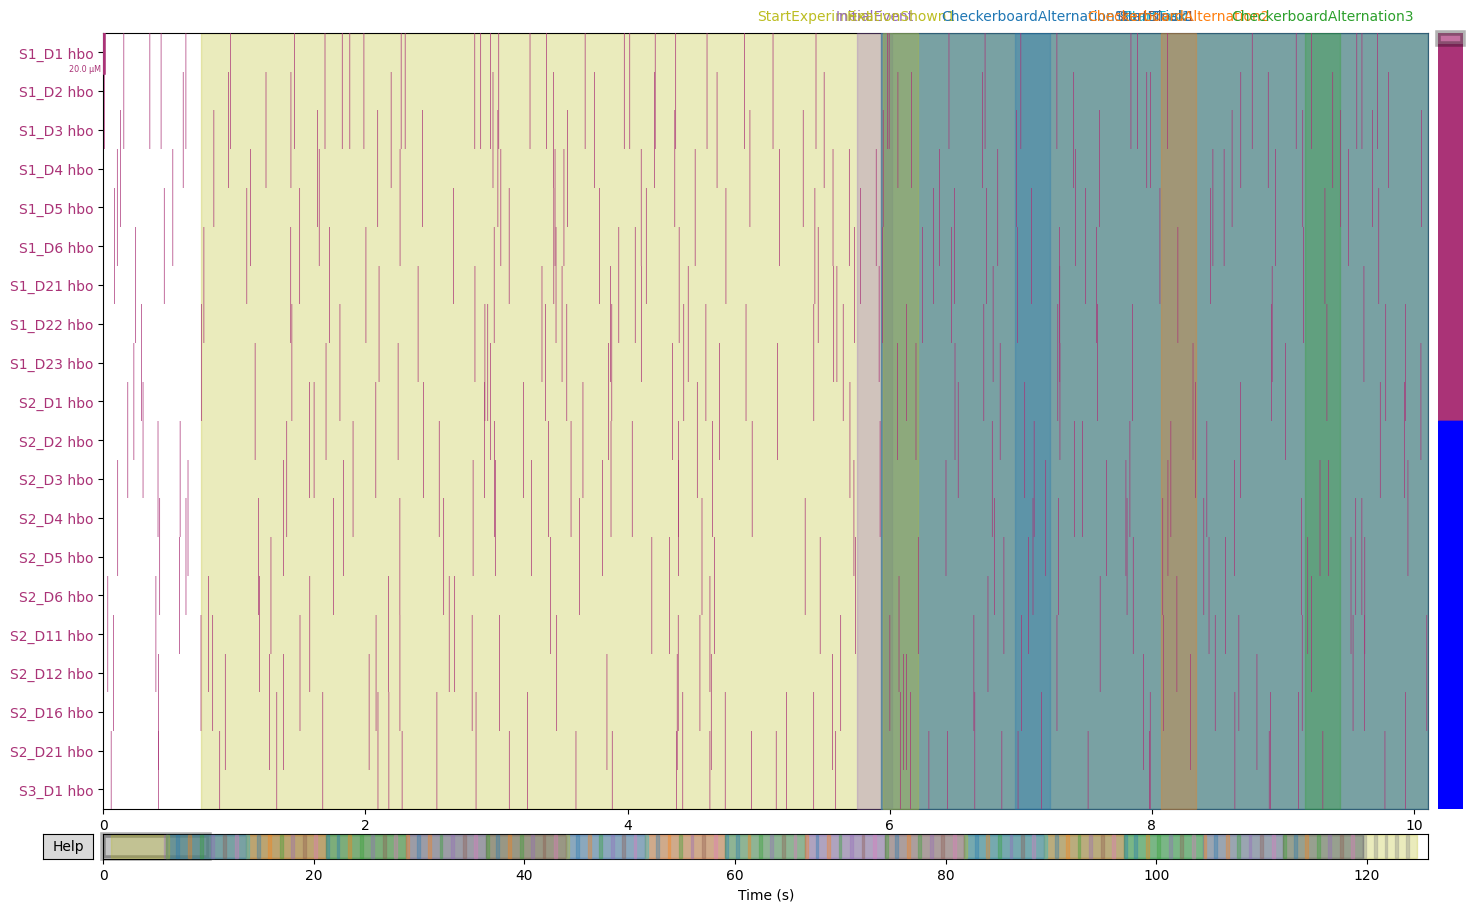

NameError: name 'plt' is not defined

In [38]:
# Set a custom scaling for fNIRS data
scaling_factor = 5e-6  # Try increasing this to stretch out the y-axis (smaller number = more spread out)

# Plot the raw intensity data with custom scaling
raw_intensity.plot(scalings={'fnirs': scaling_factor}, show_options=True)

plt.show()

In [16]:
from snirf import validateSnirf
result = validateSnirf("SyBBURE/fNIRS_Analysis_Code/07_26_24_KernelTest_Ver4.snirf")
assert result, 'Invalid SNIRF file!\n' + result.display()  # Crash and display issues if the file is invalid.

/nirs/data1/measurementList1/wavelengthIndex             FATAL   REQUIRED_DATASET_MISSING
/nirs/data1/measurementList2/wavelengthIndex             FATAL   REQUIRED_DATASET_MISSING
/nirs/data1/measurementList3/wavelengthIndex             FATAL   REQUIRED_DATASET_MISSING
/nirs/data1/measurementList4/wavelengthIndex             FATAL   REQUIRED_DATASET_MISSING
/nirs/data1/measurementList5/wavelengthIndex             FATAL   REQUIRED_DATASET_MISSING
/nirs/data1/measurementList6/wavelengthIndex             FATAL   REQUIRED_DATASET_MISSING
/nirs/data1/measurementList7/wavelengthIndex             FATAL   REQUIRED_DATASET_MISSING
/nirs/data1/measurementList8/wavelengthIndex             FATAL   REQUIRED_DATASET_MISSING
/nirs/data1/measurementList9/wavelengthIndex             FATAL   REQUIRED_DATASET_MISSING
/nirs/data1/measurementList10/wavelengthIndex            FATAL   REQUIRED_DATASET_MISSING
/nirs/data1/measurementList11/wavelengthIndex            FATAL   REQUIRED_DATASET_MISSING
/nirs/data

TypeError: can only concatenate str (not "NoneType") to str

In [11]:
import numpy as np

# Check if there are any NaNs in the raw_intensity data
nan_check = np.isnan(raw_intensity.get_data()).any()

if nan_check:
    print("NaN values found in raw_intensity data")
else:
    print("No NaN values found in raw_intensity data")

#write_raw_snirf(raw_intensity, "KernelTest_Ver4")


No NaN values found in raw_intensity data


ValueError: nan is not in list

In [17]:
raw_od = optical_density(raw_intensity)
write_raw_snirf(raw_od, "test_raw_od.snirf")

result = snirf.validateSnirf("test_raw_od.snirf")
assert result.is_valid()
result.display()

RuntimeError: None must operate on continuous wave data, but none was found.